<a href="https://colab.research.google.com/github/rafaelvareto/maximal-entropy-loss/blob/master/openset_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open-set evaluation on E-MNIST and K-MNIST with PyTorch

This notebook is a simple example of how Maximal-Entropy Loss (MEL) outperforms the conventional Cross-Entropy Loss in open-set classification tasks. As thoroughly described in two peer-reviewed papers ([journal](https://doi.org/10.1016/j.imavis.2023.104862),[conference](https://doi.org/10.1109/SIBGRAPI59091.2023.10347168)), MEL increases the entropy for negative samples and attaches a penalty to known target classes in pursuance of gallery specialization.

> The following code explains how MEL can be used with the PyTorch framework.
* Letters from E-MNIST dataset are employed as the target known classes (gallery set).
* Digits from MNIST dataset are used as negative training samples.
* Korean digits from K-MNIST provides unknown samples popping up during evaluation time.

> Cross-Entropy Loss requires an additional class encompassing negative samples during training time (27th category) whereas Maximal-Entropy Loss expects negative samples to hold negative target ids (label < 0).

In [1]:
#@title Import Dependencies

import bob.measure
import torch
import torchvision

from torch.autograd import Variable

In [2]:
#@title Define Hyperparameters

input_size  = 784
hidden_size = 1024

batch_size  = 100
learn_rate  = 3e-4
num_epochs  = 15

In [3]:
#@title Downloading E-MNIST & K-MNIST data

train_data         = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_neg_data_cel = torchvision.datasets.EMNIST(root='./data', split='mnist',   train=True, transform=torchvision.transforms.ToTensor(), download=True, target_transform=lambda _:len(train_data.classes))
train_neg_data_mel = torchvision.datasets.EMNIST(root='./data', split='mnist',   train=True, transform=torchvision.transforms.ToTensor(), download=True, target_transform=lambda _:-1)

probe_data         = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, transform=torchvision.transforms.ToTensor(), download=True)
probe_unk_data_cel = torchvision.datasets.KMNIST(root='./data',                  train=False, transform=torchvision.transforms.ToTensor(), download=True, target_transform=lambda _:len(train_data.classes))
probe_unk_data_mel = torchvision.datasets.KMNIST(root='./data',                  train=False, transform=torchvision.transforms.ToTensor(), download=True, target_transform=lambda _:-1)

In [4]:
#@title Concatenating & Loading datasets

train_loader_cel = torch.utils.data.DataLoader(
    dataset=torch.utils.data.ConcatDataset([train_data, train_neg_data_cel]),
    batch_size=batch_size, shuffle=True
)
train_loader_mel = torch.utils.data.DataLoader(
    dataset=torch.utils.data.ConcatDataset([train_data, train_neg_data_mel]),
    batch_size=batch_size, shuffle=True
)

probe_loader_cel = torch.utils.data.DataLoader(
    dataset=torch.utils.data.ConcatDataset([probe_data, probe_unk_data_cel]),
    batch_size=batch_size, shuffle=False
)
probe_loader_mel = torch.utils.data.DataLoader(
    dataset=torch.utils.data.ConcatDataset([probe_data, probe_unk_data_mel]),
    batch_size=batch_size, shuffle=False
)

In [5]:
#@title Define Model and MEL classes

class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc01 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc02 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc01(x)
        out = self.relu(out)
        out = self.fc02(out)
        return out


class MaximalEntropyLoss(torch.nn.Module):
    def __init__(self, num_classes:int, margin:float=0.35, reduction:str='mean'):
        super(MaximalEntropyLoss, self).__init__()
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        self.margin = margin
        self.num_classes = num_classes
        self.reduction = reduction

        self.eye = torch.eye(self.num_classes, device=device)
        self.ones = torch.ones(self.num_classes, device=device)
        self.unknowns_multiplier = 1.0 / self.num_classes

    def forward(self, logits:torch.Tensor, targets:torch.Tensor, sample_weights:torch.Tensor=None):
        # initialize variables with zeros
        categorical_targets = torch.zeros_like(logits)
        margin_logits = torch.zeros_like(logits)
        # get boolean tensor (true/false) indicating elements satisfying criteria
        neg_indexes = (targets  < 0)
        pos_indexes = (targets >= 0)
        # convert interger targets to categorial tensors
        categorical_targets[pos_indexes, :] = self.eye[targets[pos_indexes]]
        categorical_targets[neg_indexes, :] = self.ones.expand(neg_indexes.count_nonzero().item(), self.num_classes) * self.unknowns_multiplier
        # applying margin to target classes to force network to learn better parameters
        target_logits = logits - self.margin
        margin_logits[pos_indexes] = logits[pos_indexes] * (1 - self.eye[targets[pos_indexes]]) + target_logits[pos_indexes] * self.eye[targets[pos_indexes]]
        margin_logits[neg_indexes] = logits[neg_indexes]
        # obtain negative log softmax in range [0, +inf)
        negative_log_values = (-1) * torch.nn.functional.log_softmax(margin_logits, dim=1)
        # obtain ground-truth loss for knowns and distributed loss for unknown classes (element wise)
        loss = negative_log_values * categorical_targets
        # get loss for each sample in batch
        loss = torch.sum(loss, dim=1)
        # compute weighted loss
        if sample_weights is not None:
            loss = loss * sample_weights
        # return batch mean loss
        if   self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum':  return loss.sum()
        else: return loss

In [6]:
#@title Build the model

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_classes = len(train_data.classes)
num_samples = len(train_data) + len(train_neg_data_cel)

model_cel = NeuralNetwork(input_size, hidden_size, num_classes+1).to(device)
model_mel = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

In [7]:
#@title Define Cost functions & Optimizers

criterion_cel = torch.nn.CrossEntropyLoss(reduction='mean')
criterion_mel = MaximalEntropyLoss(num_classes=num_classes, margin=0.35, reduction='mean')

optimizer_cel = torch.optim.Adam(model_cel.parameters(), lr=learn_rate)
optimizer_mel = torch.optim.Adam(model_mel.parameters(), lr=learn_rate)

In [8]:
#@title Define Training and Evaluating classes

def train_network(loader, model, criterion, optimizer, num_epochs, num_samples, device):
    for epoch_id in range(num_epochs):
        print(f'Epoch [{epoch_id+1}/{num_epochs}]', end='\t')
        for batch_id ,(images,labels) in enumerate(loader):
            images = images.view(-1,28*28).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (batch_id+1) % 300 == 0:
                print(f'[{batch_id+1}/{num_samples//batch_size} = {loss.item():.4f}]', end=' ')
        print()
    return model

print('Training network with Cross-Entropy Loss')
model_cel = train_network(train_loader_cel, model_cel, criterion_cel, optimizer_cel, num_epochs, num_samples, device)
print('Training network with Maximal-Entropy Loss')
model_mel = train_network(train_loader_mel, model_mel, criterion_mel, optimizer_mel, num_epochs, num_samples, device)

Training network with Cross-Entropy Loss
Epoch [1/15]	[300/1848 = 1.3191] [600/1848 = 1.0328] [900/1848 = 0.8079] [1200/1848 = 0.6967] [1500/1848 = 0.6887] [1800/1848 = 0.5803] 
Epoch [2/15]	[300/1848 = 0.6316] [600/1848 = 0.6248] [900/1848 = 0.6778] [1200/1848 = 0.4207] [1500/1848 = 0.5554] [1800/1848 = 0.4496] 
Epoch [3/15]	[300/1848 = 0.4082] [600/1848 = 0.3918] [900/1848 = 0.4528] [1200/1848 = 0.3786] [1500/1848 = 0.3951] [1800/1848 = 0.4657] 
Epoch [4/15]	[300/1848 = 0.3174] [600/1848 = 0.5494] [900/1848 = 0.5841] [1200/1848 = 0.4429] [1500/1848 = 0.4614] [1800/1848 = 0.3229] 
Epoch [5/15]	[300/1848 = 0.3562] [600/1848 = 0.4165] [900/1848 = 0.4437] [1200/1848 = 0.4330] [1500/1848 = 0.3143] [1800/1848 = 0.5487] 
Epoch [6/15]	[300/1848 = 0.2810] [600/1848 = 0.2796] [900/1848 = 0.4146] [1200/1848 = 0.2920] [1500/1848 = 0.3870] [1800/1848 = 0.3592] 
Epoch [7/15]	[300/1848 = 0.3491] [600/1848 = 0.4434] [900/1848 = 0.2464] [1200/1848 = 0.3436] [1500/1848 = 0.2543] [1800/1848 = 0.2565] 


In [9]:
#@title Evaluating the accuracy of the models

def evaluate_network(loader, model, neg_class=-1, device='cpu'):
    neg_pos_scores, overall_accuracy = list(), list()
    for (images, labels) in loader:
        images = images.view(-1,28*28).to(device)
        labels = labels.to(device)

        results = model(images)
        for (result, label) in zip(results, labels):
            neg = [value.item() for (idx,value) in enumerate(result) if idx != label]
            pos = result[label].item() if label != neg_class else None
            neg_pos_scores.append( (neg, pos) )
    return neg_pos_scores

neg_pos_scores_cel = evaluate_network(probe_loader_cel, model_cel, len(train_data.classes), device=device)
neg_pos_scores_mel = evaluate_network(probe_loader_mel, model_mel, device=device)

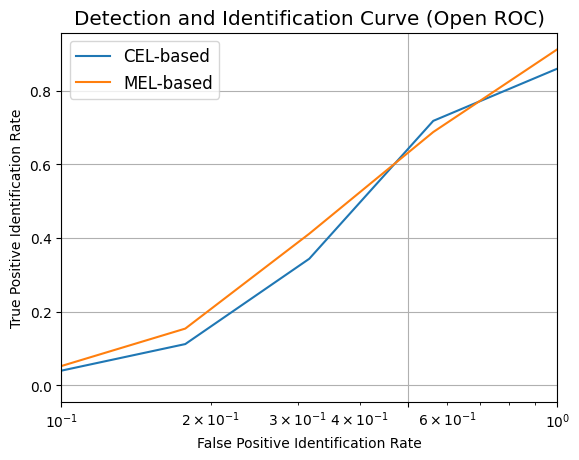

In [10]:
from matplotlib import pyplot

bob.measure.plot.detection_identification_curve(neg_pos_scores_cel, label='CEL-based')
bob.measure.plot.detection_identification_curve(neg_pos_scores_mel, label='MEL-based')
pyplot.rcParams.update({'font.size': 12})
pyplot.title('Detection and Identification Curve (Open ROC)')
pyplot.xlabel('False Positive Identification Rate')
pyplot.ylabel('True Positive Identification Rate')
pyplot.legend(loc='best')
pyplot.xlim([1e-1, 1.00])
pyplot.xticks([1e-1, 5e-1, 1.0])
pyplot.grid(True)
pyplot.show()